## Importing the data

In [94]:
# Import the data
from scipy.io import loadmat
data = loadmat('../data/beamforming/RF.mat', simplify_cells = True)
RF = data['RF']
param = data['param']

In [95]:
# Peek into param dictionary
print("param =", param.keys())
print(RF.shape) 
print('sampling fequency =', param['RxFreq'])

param = dict_keys(['TwFreq', 'NbHcycle', 'DutyCycle', 'ApodFct', 'Depth', 'ReceivingElts', 'RxFreq', 'TGC', 'pitch'])
(2176, 128)
sampling fequency = 36


It is important to note that the units are:
- MHz for frequency 
- mm for length

## Beamforming 

In order to reconstruct the point wise signal $s(z,x)$ the mesured echos at time $t$ and position $x_i$, noted as $RF(x_i,t)$, one shall add coherently add the latter contributions coming from every element of the ultrasonic array and accounting for the travel time $\tau(x_i,x,z)$ of the wave coming from point $(x,z)$ to the element at position $x_i$.
Therefore the signal is given by the formula
$$
s(x,z) = \int_{x-a}^{x+a} RF(x_1, \tau(x_1, x, z))dx_1
$$


with travel time being 
$$
\tau (x_1, x, z) = \left(z+ \sqrt{z^2+(x-x_1)^2}\right)/c
$$

### Implementation of the reconstruction 

In [96]:
import numpy as np

In [97]:
# Set the domain parameters
c0 = 1.524 # speed of sound in water (mm/us)
fs = param['RxFreq'] # sampling frequency (MHz)
T = np.size(RF, 0) / fs # sampling time (us)
Depth = c0 * T / 2 # total depth (mm)
dx = param['pitch'] # lateral sampling distance (mm)

# Domain discretization
X = np.arange(0, np.size(RF, 1)) * dx # lateral domain (mm)
#Z = np.linspace(0, Depth, np.size(RF, 0)) # axial domain (mm)
Z = (c0 * np.arange(0,np.size(RF, 0))/fs)/2  # axial domain (mm)

In [98]:
# compute the travel time from (x, 0) to (x, z) to (x1, 0) (us)
def travel_time(x, x1, z, c = c0):
    return (z + np.sqrt((x - x1)**2 + z**2)) / c

def travel_time_idx(x, x1, z, c = c0):
    return np.round(travel_time(x, x1, z, c) * fs).astype(int)

In [99]:
# set imaging domain
Imaging_domain = Z[(Z>5) & (Z<35)]

S = np.zeros((len(Imaging_domain), len(X)))
X_elts = X

for i in range(len(Imaging_domain)):
     for j in range(len(X)):
        x, z = X[j], Imaging_domain[i]

        Tau_discrete = travel_time_idx(x, X_elts, z) # Discretize the time
        contribution_indices = (Tau_discrete, np.arange(len(X_elts))) # Indices of the RF data that contribute to the imaging point
        
        S[i,j] = np.sum(RF[contribution_indices])

S_abs = np.abs(S)
S_abs = S_abs / np.max(S_abs)

/tmp/ipykernel_4907/3051124809.py:11: RuntimeWarning: divide by zero encountered in log
  axis[2].imshow(np.log(S_abs), extent=[X[0], X[-1], Imaging_domain[-1], Imaging_domain[0]], aspect='auto')


Text(0.5, 1.0, '$log|S(x,z)|$')

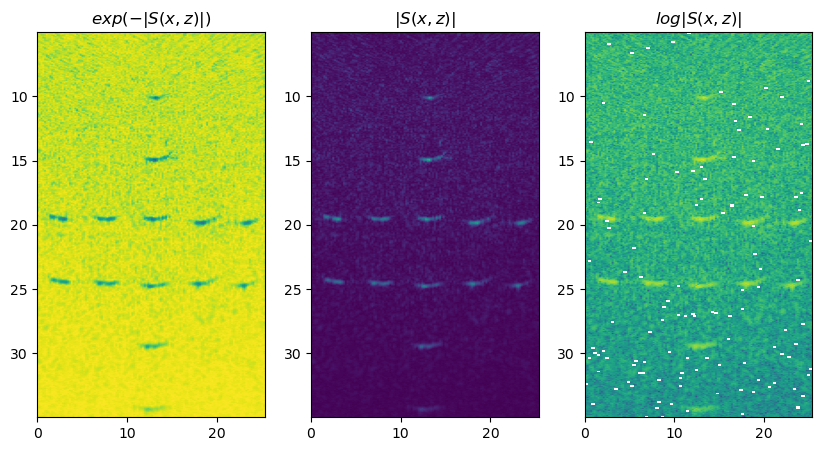

In [100]:
import matplotlib.pyplot as plt
# set figure size
plt.rcParams['figure.figsize'] = [10, 5]
figure, axis = plt.subplots(1, 3) 
axis[0].imshow(np.exp(-S_abs), extent=[X[0], X[-1], Imaging_domain[-1], Imaging_domain[0]], aspect='auto')
axis[0].set_title("$exp(-|S(x,z)|)$")

axis[1].imshow(S_abs, extent=[X[0], X[-1], Imaging_domain[-1], Imaging_domain[0]], aspect='auto')
axis[1].set_title("$|S(x,z)|$")

axis[2].imshow(np.log(S_abs), extent=[X[0], X[-1], Imaging_domain[-1], Imaging_domain[0]], aspect='auto')
axis[2].set_title("$log|S(x,z)|$")